# SVM Method : EMU-Fight

This notebook shows the emulation of the two point correlation data.

***This notebook provides a template to build an emulator with a particular method, using stand-alone libraries. If you want to use the emulators on the emulator class, refer to [].***

#### Index<a name="index"></a>
1. [Import packages](#imports)
* [Load data](#loadData)
 1. [Load train data](#loadTrainData)
 * [Load test data](#loadTestData)
1. [Visualiazing the dataset](#visualization)
* [Emulator method](#emulator)

## 1. Import packages<a name="imports"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## 2. Load data<a name="loadData"></a>

Read the training data from a `.npy` file:

### 2.1. Load train data<a name="loadTrainData"></a>

In [2]:
train_file = '../data/cosmology_train.npy'
train_data = np.load(train_file, allow_pickle=True)

The cosmology dataset contains cosmological parameters (Omega_m, sigma8, Omega_b) as inputs, and the correlation function as output. The correlation function is measured at 10 separation values $r$.

### 2.2. Load test data<a name="loadTestData"></a>

In [3]:
test_file = '../data/cosmology_test.npy'
test_data = np.load(test_file, allow_pickle=True)

## 3. Visualiazing the dataset<a name="visualization"></a>

#### 3.1 Data Structure: Dictionary

The cosmology dataset contains cosmological parameters (Omega_m, sigma8, Omega_b) as inputs, and the correlation function as output. The correlation function is measured at 10 separation values  𝑟 .

In [63]:
n_test = train_data.shape[0]
print("Number of datapoints:", n_test)
print("Dict keys:", train_data[0].keys())

Number of datapoints: 1000
Dict keys: dict_keys(['x', 'y', 'label'])


In [64]:
train_data[0]['label']

0

In [65]:
train_data[0]['x']

array([0.26 , 0.7  , 0.038])

In [66]:
print(train_data[0]['y'])

print()
print('nsize:',train_data[0]['y'].size)

[ 7.28099888e-03  3.81211294e-03  2.05146145e-03  1.16017937e-03
  8.31225643e-04  1.00322037e-03  1.13735983e-03  5.13176786e-04
 -2.66707286e-05 -1.87205919e-04]

nsize: 10


#### 3.2 Reading the data vector

In [77]:
def read_dict(data,col='x'):
    return np.array([cell[col] for cell in data])

In [111]:
r_vals = np.linspace(50, 140, 10)
ylabel = read_dict(train_data,col='label')
xs_train = read_dict(train_data)
ys_train = read_dict(train_data,col='y')

print("Number of input parameters:", xs_train.shape[1])
print("Number of output values:", ys_train.shape[1])

Number of input parameters: 3
Number of output values: 10


In [79]:
xvec

array([[0.26      , 0.7       , 0.038     ],
       [0.26      , 0.7       , 0.04022222],
       [0.26      , 0.7       , 0.04244444],
       ...,
       [0.34      , 0.95      , 0.05355556],
       [0.34      , 0.95      , 0.05577778],
       [0.34      , 0.95      , 0.058     ]])

In [47]:
yvec

array([[ 7.28099888e-03,  3.81211294e-03,  2.05146145e-03, ...,
         5.13176786e-04, -2.66707286e-05, -1.87205919e-04],
       [ 7.54246222e-03,  3.97928522e-03,  2.16263194e-03, ...,
         5.13923259e-04, -4.50182311e-05, -1.96770404e-04],
       [ 7.81406152e-03,  4.15411087e-03,  2.28001454e-03, ...,
         5.08430125e-04, -6.26070570e-05, -2.05380401e-04],
       ...,
       [ 8.00880540e-03,  3.79057048e-03,  1.84581393e-03, ...,
        -4.49942500e-04, -4.58953044e-04, -3.89618292e-04],
       [ 8.30507408e-03,  3.97441350e-03,  1.96832738e-03, ...,
        -4.69254558e-04, -4.67148388e-04, -3.98033813e-04],
       [ 8.61203211e-03,  4.16612658e-03,  2.09737867e-03, ...,
        -4.86726514e-04, -4.75138521e-04, -4.06853689e-04]])

#### 3.3 Visualizing the dataset

Text(0, 0.5, '$\\xi(r)$')

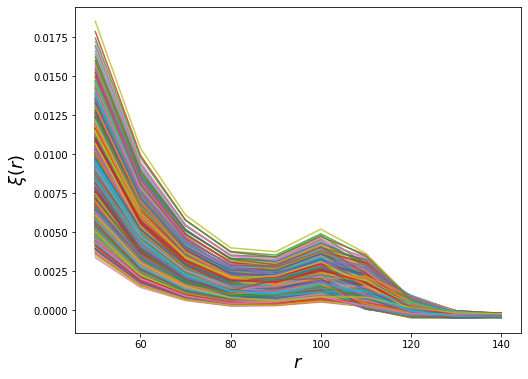

In [75]:
plt.figure(figsize=(8,6))
ys_train_plot = ys_train.copy()
np.random.shuffle(ys_train_plot) # shuffle so that color order isn't weird
plt.plot(r_vals, ys_train_plot.T, alpha=0.8)

plt.xlabel('$r$',fontsize=18)
plt.ylabel(r'$\xi(r)$',fontsize=18)

# plt.xscale('log')
# plt.yscale('log')


Let's do the same for our test set:

In [76]:
n_test = test_data.shape[0]
print("Number of datapoints:", n_test)
print("Dict keys:", data_test[0].keys(),'\n')

xs_test = read_dict(test_data)
ys_test = read_dict(test_data,col='y')
print("Number of input parameters:", xs_test.shape[1])
print("Number of output values:", ys_test.shape[1])

Number of datapoints: 100
Dict keys: dict_keys(['x', 'y', 'label']) 

Number of input parameters: 3
Number of output values: 10


Text(0, 0.5, '$\\xi(r)$')

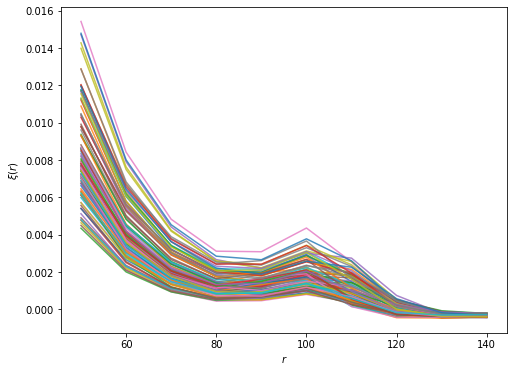

In [73]:
plt.figure(figsize=(8,6))
plt.plot(r_vals, ys_test.T, alpha=0.8)
plt.xlabel('$r$')
plt.ylabel(r'$\xi(r)$')

In [113]:
np.c_[r_vals,ys_test[0]]

array([[ 5.00000000e+01,  7.14041783e-03],
       [ 6.00000000e+01,  3.33790354e-03],
       [ 7.00000000e+01,  1.59181435e-03],
       [ 8.00000000e+01,  8.91260574e-04],
       [ 9.00000000e+01,  1.21754389e-03],
       [ 1.00000000e+02,  1.66417143e-03],
       [ 1.10000000e+02,  3.08356060e-04],
       [ 1.20000000e+02, -3.75246978e-04],
       [ 1.30000000e+02, -4.12970018e-04],
       [ 1.40000000e+02, -3.50794980e-04]])

## 4. Emulator method<a name="emulator"></a>

SVM Method

based on this example: https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py

array([{'x': array([0.26 , 0.7  , 0.038]), 'y': array([ 7.28099888e-03,  3.81211294e-03,  2.05146145e-03,  1.16017937e-03,
        8.31225643e-04,  1.00322037e-03,  1.13735983e-03,  5.13176786e-04,
       -2.66707286e-05, -1.87205919e-04]), 'label': 0},
       {'x': array([0.26      , 0.7       , 0.04022222]), 'y': array([ 7.54246222e-03,  3.97928522e-03,  2.16263194e-03,  1.24336503e-03,
        9.21158397e-04,  1.14679432e-03,  1.25605659e-03,  5.13923259e-04,
       -4.50182311e-05, -1.96770404e-04]), 'label': 1},
       {'x': array([0.26      , 0.7       , 0.04244444]), 'y': array([ 7.81406152e-03,  4.15411087e-03,  2.28001454e-03,  1.33261726e-03,
        1.02001979e-03,  1.30435437e-03,  1.37218171e-03,  5.08430125e-04,
       -6.26070570e-05, -2.05380401e-04]), 'label': 2},
       {'x': array([0.26      , 0.7       , 0.04466667]), 'y': array([ 8.09625833e-03,  4.33700120e-03,  2.40401271e-03,  1.42840872e-03,
        1.12860721e-03,  1.47639559e-03,  1.48382895e-03,  4.97737406e

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(data_vector, ylabels)


predictions = svm_reg.predict(xs_test)
svm_mse = mean_squared_error(ylabels, predictions)
svm_rmse = np.sqrt(svm_mse)

print(svm_rmse)